In [1]:
# # imports all helper classes/functions from utils.py, including other dependancies
# from utils_new import *

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math


class Dataset():
    def __init__(self, filenames, apt_filename):
        '''
        This Dataset class serves to process data for GFET data, for a single data well, including
        multiple devices per well, over the gate voltage sweeps for multiple concentrations.
        
        Parameters:
            filenames: list of filenames that contains gate voltage sweeps, each for a single concentration
            apt_filename: the filename of the voltage sweep for the devices with only the aptamer
        Returns:
            None

        Format of each file:
            First column: gate voltage
            All other columns: Drain-Source Resistance for a single device. Each row shows the resistance
            experienced by each device for the gate voltage of the 1st column.
        '''
        self.num_concs = len(filenames) # number of concentrations tested
        self.num_devices = 10000 # number of devices in the well at hand, set super high to start it will get smaller later
        self.num_voltages = 10000 # number of voltages to sweep over. This can change over concentrations, so take the max
        self.voltages = [] # list of the voltages we sweep over
        for conc in range(self.num_concs): # calcluate the voltages list, number of voltages, and number of devices
            raw_data = np.loadtxt('data/'+filenames[conc]).T
            if len(raw_data[0,:]) > len(self.voltages): 
                self.voltages = raw_data[0,:]
            self.num_devices = min(raw_data.shape[0] - 1, self.num_devices)
            self.num_voltages = max(len(self.voltages), self.num_voltages)
        # self.voltages = self.voltages[:self.num_voltages]

        
        self.apt_resistances = {} # dictionary of lists of aptemer resistances. {device_number: resistance_list}
        for dev_num in range(self.num_devices):
            raw_data = np.loadtxt('data/'+apt_filename).T
            self.apt_resistances[dev_num] = raw_data[dev_num+1]
        self.resistances = {}  # dictionary of dictionary of resistance list. {concentration_num: {device_number: list_of_resistances}}
        for conc in range(self.num_concs):
            conc_data_dic = {}
            for dev_num in range(self.num_devices):
                raw_data = np.loadtxt('data/'+filenames[conc]).T
                conc_data_dic[dev_num] = raw_data[dev_num+1]
            self.resistances[conc] = conc_data_dic

        self.resistance_derivatives = {} # dictionary of dictionary of delta resistance list. {concentration_num: {device_number: list_of_resistance_changes}}
        for conc in range(self.num_concs):
            conc_resistance_derivative = {}
            for dev_num in range(self.num_devices): 
                conc_resistance_derivative[dev_num] = [self.resistances[conc][dev_num][i] - self.resistances[conc][dev_num][i+1] for i in range(len(self.resistances[conc][dev_num])-1)]
            self.resistance_derivatives[conc] = conc_resistance_derivative
        self.apt_resistance_derivatives = {} # dictionary of lists of aptemer delta resistance. {device_number: list_of_resistance_changes}
        for dev_num in range(self.num_devices): 
            self.apt_resistance_derivatives[dev_num] = [self.apt_resistances[dev_num][i] - self.apt_resistances[dev_num][i+1] for i in range(len(self.apt_resistances[dev_num])-1)]

        self.apt_dirac_voltages = {} # dictionary of lists for dirac voltages for the aptemer. The list enumerates the concentrations. {device_number: dirac_voltage_list}
        for dev_num in range(self.num_devices):
            self.apt_dirac_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistances[dev_num])]
        self.dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltages. x:concentration, y: device_number
        self.adj_dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])]
                self.adj_dirac_voltages[conc,dev_num] = self.voltages[np.argmax(self.resistances[conc][dev_num])] - self.apt_dirac_voltages[dev_num]

        self.apt_pos_transc_voltages = {} # dictionary of lists for positive transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: pos_transc_v_list}
        self.apt_neg_transc_voltages = {}# dictionary of lists for negative transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: neg_transc_v_list}
        for dev_num in range(self.num_devices):
                self.apt_pos_transc_voltages[dev_num] = self.voltages[np.argmax(self.apt_resistance_derivatives[dev_num])]
                self.apt_neg_transc_voltages[dev_num] = self.voltages[np.argmin(self.apt_resistance_derivatives[dev_num])]
        self.pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltages. x:concentration, y: device_number
        self.neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltages. x:concentration, y: device_number
        self.adj_pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltage shifts (adjusted). x:concentration, y: device_number
        self.adj_neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])]
                self.neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])]
                self.adj_pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.resistance_derivatives[conc][dev_num])] - self.apt_pos_transc_voltages[dev_num]
                self.adj_neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.resistance_derivatives[conc][dev_num])] - self.apt_neg_transc_voltages[dev_num]

        self.apt_conductances = {dev_num: 1/self.apt_resistances[dev_num] for dev_num in range(self.num_devices)} # dictionary of lists of conductances for the aptamer readings. {device_number: conductance_list}
        self.conductances = {} # dictionary of dictionaries of lists for conductance readings. {concentration: {device_number: conductance_list}}
        for conc in range(self.num_concs):
            self.conductances[conc] = [1 / self.resistances[conc][dev_num] for dev_num in range(self.num_devices)]

        self.norm_dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of normalized dirac voltages. x:concentration, y:device_number
        for dev_num in range(self.num_devices):
            # max_dirac_voltage_shift = max(adj_dirac_voltages[:,dev_num])
            self.norm_dirac_voltages[:,dev_num] = self.adj_dirac_voltages[:,dev_num] / max(self.adj_dirac_voltages[:,dev_num])



        
        # self.pos_transc_conductances = np.zeros((self.num_concs, self.num_devices))
        # for conc in range(self.num_concs):
        #     for dev_num in range(self.num_devices):
        #         # print(self.pos_transc_voltages[conc][dev_num]//0.02)
        #         self.pos_transc_conductances[conc][dev_num] = 1 / self.resistances[conc][dev_num][int(self.pos_transc_voltages[conc][dev_num]//0.02)] - self.apt_conductances[dev_num][int(self.pos_transc_voltages[conc][dev_num]//0.02)] # change this to not be dependant on 0.02


        # self.neg_transc_conductances = np.zeros((self.num_concs, self.num_devices))
        # for conc in range(self.num_concs):
        #     for dev_num in range(self.num_devices):
        #         # print(self.neg_transc_voltages[conc][dev_num]//0.02)
        #         self.neg_transc_conductances[conc][dev_num] = 1 / self.resistances[conc][dev_num][int(self.neg_transc_voltages[conc][dev_num]//0.02)] - self.apt_conductances[dev_num][int(self.neg_transc_voltages[conc][dev_num]//0.02)] # change this to not be dependant on 0.02









    
    def conductance_shifts(self, voltage_to_track):
        '''
        Calculates the conductance shift over different concentrations, for a specific gate voltage.

        Returns:
            2D array of conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        '''
        # voltage_idx = np.where(self.voltages == voltage_to_track)[0][0] # index of voltage we want to track in self.voltages
        voltage_idx = np.abs(self.voltages - voltage_to_track).argmin() # index of voltage we want to track in self.voltages
        
        conductance_at_voltage = np.zeros((self.num_concs, self.num_devices)) # 2D array of conductances. x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                conductance_at_voltage[conc, dev_num] = self.conductances[conc][dev_num][voltage_idx]

        delta_conductance = np.zeros((self.num_concs, self.num_devices)) # 2D list tracking the change in conductances. x:concentration, y: device_number
        for dev_num in range(self.num_devices):
            delta_conductance[:,dev_num] = conductance_at_voltage[:,dev_num] - self.apt_conductances[dev_num][voltage_idx]

        return delta_conductance

    
    def normalized_conductance_shifts(self, voltage_to_track):
        '''
        Calculates the normalized conductance shift over different concentrations, for a specific gate voltage.
        Normalization strategy is
                (I_0-I) / I_0 , 
        where I_0 is the first reading at 1ag/ml, the min conductance

        Returns:
            2D array of normalized conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        
        '''
        delta_G = self.conductance_shifts(voltage_to_track) # un-normalized conductance shift, 
        
        G_0 = {} # minimum conductance
        for dev_num in range(self.num_devices):
            G_0[dev_num] = min(delta_G[:,dev_num])

        G_norm = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            G_norm[:,dev_num] = delta_G[:,dev_num] / G_0[dev_num]

        return G_norm

    def analysis(self, data_array_2D):
        '''
        
        '''
        concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        data_array_flattened = data_array_2D.flatten()
        hill_coeffs, c = curve_fit(hill_function, concentrations_list, data_array_flattened)
        # std_devs = [np.std(data_array_flattened[i*self.num_devices:i*(self.num_devices+1)]) for i in range(self.num_concs)]

        std_devs = []
        for i in range(self.num_concs):
            mu = hill_function(i, *hill_coeffs)
            val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in data_array_flattened[i*self.num_devices:i*(self.num_devices+1)]]))
            std_devs.append(val)

        inf_point_x = inflection_point_hill_function(*hill_coeffs)
        slope = derivative_hill_function(inf_point_x, *hill_coeffs)
        print('inf point', inf_point_x)
        std_dev = np.mean(std_devs)
        LOD = 3.3 * std_dev / slope
        LOQ = 10 * std_dev / slope
        print(f'sensitivity: {slope:.4f}')
        print(f'LOD: {LOD}')
        print(f'LOQ: {LOQ}')
        print(f'Dynamic range: {LOD} to {LOQ}')
        
        return concentrations_list, data_array_flattened, hill_coeffs, std_devs

        ###############
        # avg_dirac_voltage = np.mean(self.dirac_voltages)
        # avg_pos_transc_voltage = np.mean(self.pos_transc_voltages)
        # avg_neg_transc_voltage = np.mean(self.neg_transc_voltages)

        # # print('d, p, n', avg_dirac_voltage, avg_pos_transc_voltage, avg_neg_transc_voltage)

        # conductance_shift_dirac_voltage = self.adj_dirac_voltages.flatten() # self.conductance_shifts(avg_dirac_voltage)
        # conductance_shift_pos_transc_voltage = self.conductance_shifts(avg_pos_transc_voltage).flatten # self.normalized_conductance_shifts(avg_pos_transc_voltage) 
        # conductance_shift_neg_transc_voltage = self.conductance_shifts(avg_neg_transc_voltage).flatten

        # concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        
        # hill_coeffs_dirac, c = curve_fit(hill_function, concentrations_list, conductance_shift_dirac_voltage)
        # hill_coeffs_conductance_pos_transc, c = (None, None)
        # hill_coeffs_conductance_neg_transc, c = (None, None)
        # # coeffs, pcov = curve_fit(hill_function, concs, conductances)
        
        # return (concentrations_list, (conductance_shift_dirac_voltage, hill_coeffs_dirac), (conductance_shift_pos_transc_voltage, hill_coeffs_conductance_pos_transc), (conductance_shift_neg_transc_voltage, hill_coeffs_conductance_neg_transc))



    def dirac_analysis(self):

        return self.analysis(self.adj_dirac_voltages)
        
        # concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        # shifted_dirac_voltages_list = self.adj_dirac_voltages.flatten()
        # hill_coeffs, c = curve_fit(hill_function, concentrations_list, shifted_dirac_voltages_list)
        # # std_devs = [np.std(shifted_dirac_voltages_list[i*self.num_devices:i*(self.num_devices+1)]) for i in range(self.num_concs)]

        # std_devs = []
        # for i in range(self.num_concs):
        #     mu = hill_function(i, *hill_coeffs)
        #     val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in shifted_dirac_voltages_list[i*self.num_devices:i*(self.num_devices+1)]]))
        #     std_devs.append(val)

        # inf_point_x = inflection_point_hill_function(*hill_coeffs)
        # slope = derivative_hill_function(inf_point_x, *hill_coeffs)
        # print('inf point', inf_point_x)
        # std_dev = np.mean(std_devs)
        # LOD = 3.3 * std_dev / slope
        # LOQ = 10 * std_dev / slope
        # print(f'sensitivity: {slope:.4f}')
        # print(f'LOD: {LOD}')
        # print(f'LOQ: {LOQ}')
        # print(f'Dynamic range: {LOD} to {LOQ}')
        
        # return concentrations_list, shifted_dirac_voltages_list, hill_coeffs, std_devs


    def dirac_analysis_normalized(self):
        return self.analysis(self.norm_dirac_voltages)
        
        # concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        # shifted_dirac_voltages_list = self.norm_dirac_voltages.flatten()
        # hill_coeffs, c = curve_fit(hill_function, concentrations_list, shifted_dirac_voltages_list)
        # # std_devs = [np.std(shifted_dirac_voltages_list[i*self.num_devices:i*(self.num_devices+1)]) for i in range(self.num_concs)]

        # std_devs = []
        # for i in range(self.num_concs):
        #     mu = hill_function(i, *hill_coeffs)
        #     val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in shifted_dirac_voltages_list[i*self.num_devices:i*(self.num_devices+1)]]))
        #     std_devs.append(val)

        # inf_point_x = inflection_point_hill_function(*hill_coeffs)
        # slope = derivative_hill_function(inf_point_x, *hill_coeffs)
        # print('inf point', inf_point_x)
        # std_dev = np.mean(std_devs)
        # LOD = 3.3 * std_dev / slope
        # LOQ = 10 * std_dev / slope
        # print(f'sensitivity: {slope:.4f}')
        # print(f'LOD: {LOD}')
        # print(f'LOQ: {LOQ}')
        # print(f'Dynamic range: {LOD} to {LOQ}')
        
        # return concentrations_list, shifted_dirac_voltages_list, hill_coeffs, std_devs


    def pos_transc_conduc_analysis(self):
        avg_pos_transc_voltage = np.mean(self.pos_transc_voltages)
        # avg_pos_transc_voltage = 0.9
        
        concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        conductance_shift_pos_transc_voltage = self.conductance_shifts(avg_pos_transc_voltage).flatten()
        # conductance_shift_pos_transc_voltage = self.pos_transc_conductances.flatten()
        hill_coeffs, c = curve_fit(hill_function, concentrations_list, conductance_shift_pos_transc_voltage)
        # std_devs = [np.std(conductance_shift_pos_transc_voltage[i*self.num_devices:i*(self.num_devices+1)]) for i in range(self.num_concs)]

        std_devs = []
        for i in range(self.num_concs):
            mu = hill_function(i, *hill_coeffs)
            val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in conductance_shift_pos_transc_voltage[i*self.num_devices:i*(self.num_devices+1)]]))
            std_devs.append(val)

        inf_point_x = inflection_point_hill_function(*hill_coeffs)
        slope = derivative_hill_function(inf_point_x, *hill_coeffs)
        print('inf point', inf_point_x)
        std_dev = np.mean(std_devs)
        LOD = 3.3 * std_dev / slope
        LOQ = 10 * std_dev / slope
        print(f'sensitivity: {slope}') # :.4f}')
        print(f'LOD: {LOD}')
        print(f'LOQ: {LOQ}')
        print(f'Dynamic range: {LOD} to {LOQ}')

        return concentrations_list, conductance_shift_pos_transc_voltage, hill_coeffs, std_devs

    def neg_transc_conduc_analysis(self):
        avg_neg_transc_voltage = np.mean(self.neg_transc_voltages)
        # avg_neg_transc_voltage = 0.9
        
        concentrations_list = np.repeat(range(self.num_concs), self.num_devices)
        conductance_shift_neg_transc_voltage = self.conductance_shifts(avg_neg_transc_voltage).flatten()
        # conductance_shift_neg_transc_voltage = self.neg_transc_conductances.flatten()
        hill_coeffs, c = curve_fit(hill_function, concentrations_list, conductance_shift_neg_transc_voltage)
        # std_devs = [np.std(conductance_shift_neg_transc_voltage[i*self.num_devices:i*(self.num_devices+1)]) for i in range(self.num_concs)]

        std_devs = []
        for i in range(self.num_concs):
            mu = hill_function(i, *hill_coeffs)
            val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in conductance_shift_neg_transc_voltage[i*self.num_devices:i*(self.num_devices+1)]]))
            std_devs.append(val)
            
        inf_point_x = inflection_point_hill_function(*hill_coeffs)
        slope = derivative_hill_function(inf_point_x, *hill_coeffs)
        print('inf point', inf_point_x)
        std_dev = np.mean(std_devs)
        LOD = 3.3 * std_dev / slope
        LOQ = 10 * std_dev / slope
        print(f'sensitivity: {slope}') # :.4f}')
        print(f'LOD: {LOD}')
        print(f'LOQ: {LOQ}')
        print(f'Dynamic range: {LOD} to {LOQ}')

        return concentrations_list, conductance_shift_neg_transc_voltage, hill_coeffs, std_devs
        

def hill_function(x, A, K, n, b):
    return A * (x**n) / (K**n + x**n) + b

def derivative_hill_function(x, A, K, n, b):
    return A * n * K**n * (x**(n-1)) / (K**n + x**n)**2

def inflection_point_hill_function(A, K, n, b):
    return K* ((n-1)/(n+1))**(1/n)

# def downward_hill_function(x, A, K, n, b):
#     return A * (1 - (x**n) / (K**n + x**n)) + b

# def inverse_hill_function(y, A, K, n, b):
#     return np.power(((y - b) * K**n) / (A - (y - b)), 1/n)
            
        

    

C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\1563015081.py:336: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


inf point 2.490794849152803
sensitivity: 0.0622
LOD: 1.1629010060453944
LOQ: 3.5239424425618013
Dynamic range: 1.1629010060453944 to 3.5239424425618013


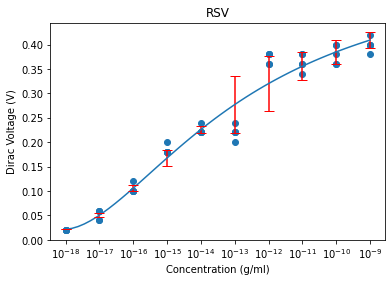

C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\1563015081.py:336: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\1563015081.py:336: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b


inf point 2.4934010185364435
sensitivity: 0.1557
LOD: 1.0022684017763686
LOQ: 3.037176975079905
Dynamic range: 1.0022684017763686 to 3.037176975079905


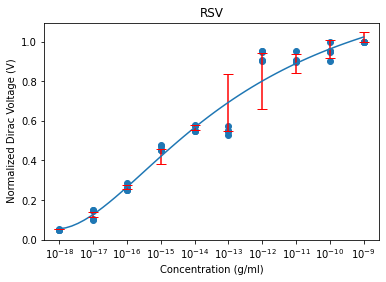

inf point 1.8512336664244862
sensitivity: -5.018883882638723e-05
LOD: -1.5164300718767578
LOQ: -4.595242642050781
Dynamic range: -1.5164300718767578 to -4.595242642050781


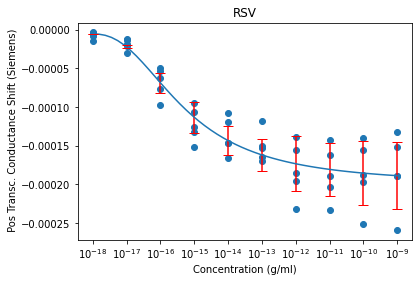

C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\1563015081.py:336: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\1563015081.py:336: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b


inf point 3.7925481910948706
sensitivity: 1.8871668142516905e-05
LOD: 6.70455720983716
LOQ: 20.316840029809576
Dynamic range: 6.70455720983716 to 20.316840029809576


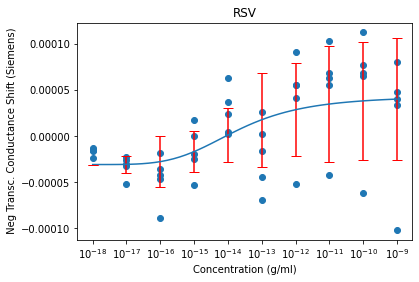

In [89]:
# for RSV, well 3

# filenames to inlude for each concentration
filenames = ['BCdata_B48C13_rsv_1ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_10ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_100ag_lastsweep.txt', 
             'BCdata_B48C13_rsv_1fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100fg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_10pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_100pg_lastsweep.txt', 
             'BCdata_B48C13_rsv_1ng_lastsweep.txt']

filename_aptamer = 'BCdata_B48C13_rsv_aptamers_lastsweep.txt'

dataset = Dataset(filenames, filename_aptamer)


concs, dirac, dirac_coeffs, std_devs = dataset.dirac_analysis()
plt.scatter(concs, dirac, marker='o')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *dirac_coeffs)
plt.plot(X_fit, Y_fit) # , label=f'n={dirac_coeffs[2]:.4f}')
# plt.legend()
plt.title('RSV')
plt.xlabel("Concentration (g/ml)")
plt.ylabel("Dirac Voltage (V)")
plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *dirac_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()


concs, dirac, dirac_coeffs, std_devs = dataset.dirac_analysis_normalized()
plt.scatter(concs, dirac, marker='o')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *dirac_coeffs)
plt.plot(X_fit, Y_fit) # , label=f'n={dirac_coeffs[2]:.4f}')
# plt.legend()
plt.title('RSV')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(" Normalized Dirac Voltage (V)")
plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *dirac_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()



concs, pos_transc_conduc, pos_transc_conduc_coeffs, std_devs = dataset.pos_transc_conduc_analysis()
plt.scatter(concs, pos_transc_conduc, marker='o')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *pos_transc_conduc_coeffs)
plt.plot(X_fit, Y_fit) # , label=f'n={pos_transc_conduc_coeffs[2]:.4f}')
# plt.legend()
plt.title('RSV')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(" Pos Transc. Conductance Shift (Siemens)")
plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *pos_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()


concs, neg_transc_conduc, neg_transc_conduc_coeffs, std_devs = dataset.neg_transc_conduc_analysis()
plt.scatter(concs, neg_transc_conduc, marker='o')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *neg_transc_conduc_coeffs)
plt.plot(X_fit, Y_fit) # , label=f'n={neg_transc_conduc_coeffs[2]:.4f}')
# plt.legend()
plt.title('RSV')
plt.xlabel("Concentration (g/ml)")
plt.ylabel(" Neg Transc. Conductance Shift (Siemens)")
plt.errorbar(range(dataset.num_concs), hill_function(range(dataset.num_concs), *neg_transc_conduc_coeffs), yerr=std_devs, ecolor='red', fmt='None', capsize=5)
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()


C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


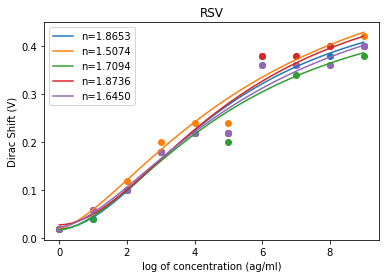

C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


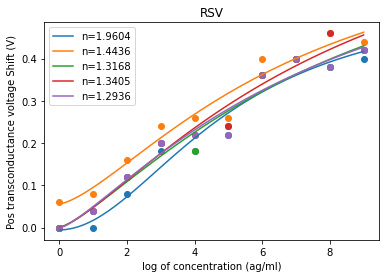

C:\Users\joeyl\AppData\Local\Temp\ipykernel_28372\712497658.py:282: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


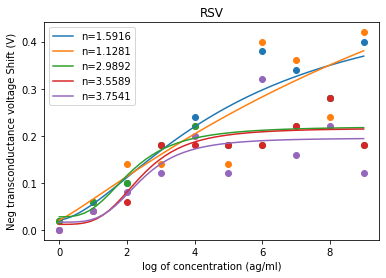

In [4]:
# dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.adj_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
plt.show()
plt.close()


# pos transconductance voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    pos_transc_voltages = dataset.adj_pos_transc_voltages[:,i]
    plt.scatter(concs, pos_transc_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, pos_transc_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Pos transconductance voltage Shift (V)")
plt.legend()
plt.show()
plt.close()

# neg transconductance voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    neg_transc_voltages = dataset.adj_neg_transc_voltages[:,i]
    plt.scatter(concs, neg_transc_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, neg_transc_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Neg transconductance voltage Shift (V)")
plt.legend()
plt.show()
plt.close()

C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


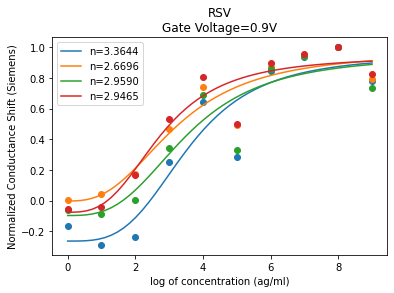

C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


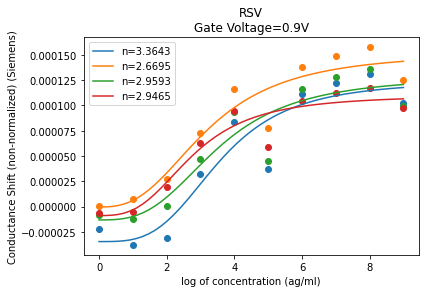

In [12]:
# conductance shifts at Gate voltage 0.9
for i in [0,1,2,4]:
    concs = range(dataset.num_concs)
    conductances = dataset.normalized_conductance_shifts(0.9)[:,i]
    plt.scatter(concs, conductances, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, conductances)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV\nGate Voltage=0.9V')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Normalized Conductance Shift (Siemens)")
plt.show()
plt.close()

# conductance shifts at Gate voltage 0.9
for i in [0,1,2,4]:
    concs = range(dataset.num_concs)
    conductances = dataset.conductance_shifts(0.9)[:,i]
    plt.scatter(concs, conductances, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, conductances)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV\nGate Voltage=0.9V')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Conductance Shift (non-normalized) (Siemens)")
plt.show()
plt.close()

C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: divide by zero encountered in power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in divide
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipyker

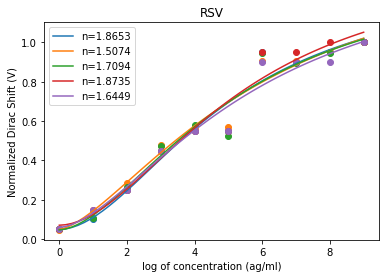

C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b
C:\Users\joeyl\AppData\Local\Temp\ipykernel_29652\860222733.py:153: RuntimeWarning: invalid value encountered in scalar power
  return A * (x**n) / (K**n + x**n) + b


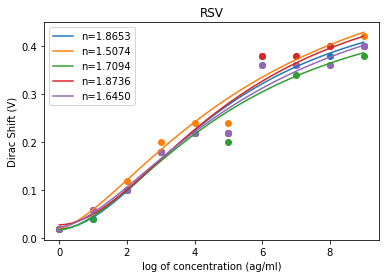

In [13]:
# normalized dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.norm_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Normalized Dirac Shift (V)")
plt.show()
plt.close()

# dirac voltage shifts
for i in range(dataset.num_devices):
    concs = range(dataset.num_concs)
    dirac_voltages = dataset.adj_dirac_voltages[:,i]
    plt.scatter(concs, dirac_voltages, marker='o')
    coeffs, pcov = curve_fit(hill_function, concs, dirac_voltages)
    X_fit = np.linspace(min(concs), max(concs), 50)
    Y_fit = hill_function(X_fit, *coeffs)
    plt.plot(X_fit, Y_fit, label=f'n={coeffs[2]:.4f}')
plt.legend()
plt.title('RSV')
plt.xlabel("log of concentration (ag/ml)")
plt.ylabel("Dirac Shift (V)")
plt.show()
plt.close()

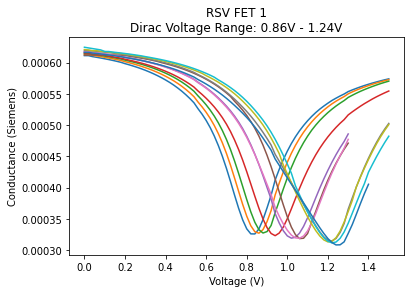

In [49]:
# normalized resistance shifts

device_number = 0
maxim = np.min(dataset.dirac_voltages[:,device_number])
minim = np.max(dataset.dirac_voltages[:,device_number])

x = [0.02*f for f in range(len(dataset.apt_conductances[device_number]))]

# print(len(x))
# print(len(dataset.conductances[device_number]))
plt.plot(x, dataset.apt_conductances[device_number]) # , label='aptamer', color='red')

# for i in range(dataset.num_devices):
for j in range(dataset.num_concs):
    # y = dataset.resistances[j][i]
    x = [0.02*f for f in range(len(dataset.conductances[j][device_number]))]
    y = dataset.conductances[j][device_number]
    plt.plot(x, y) # ,marker='o')
plt.title(f'RSV FET 1\nDirac Voltage Range: {maxim}V - {minim}V')
plt.xlabel("Voltage (V)")
plt.ylabel("Conductance (Siemens)")
# plt.legend()
plt.show()
plt.close()

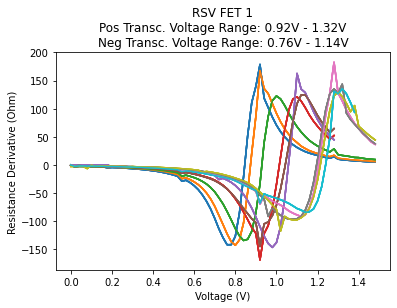

In [52]:

pos_maxim = np.max(dataset.pos_transc_voltages[:,0])
pos_minim = np.min(dataset.pos_transc_voltages[:,0])
neg_maxim = np.max(dataset.neg_transc_voltages[:,0])
neg_minim = np.min(dataset.neg_transc_voltages[:,0])

# resistance derivative shifts
for i in range(dataset.num_devices):
    for j in range(dataset.num_concs):
        i=0
        y = dataset.resistance_derivatives[j][i]
        x = [0.02*f for f in range(len(y))]
        plt.plot(x, y) #  ,marker='o')
plt.title(f'RSV FET 1\nPos Transc. Voltage Range: {pos_minim}V - {pos_maxim}V\nNeg Transc. Voltage Range: {neg_minim}V - {neg_maxim}V')
plt.xlabel("Voltage (V)")
plt.ylabel("Resistance Derivative (Ohm)")
plt.show()
plt.close()

[0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]
